### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import warnings
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sns.set(style='darkgrid')
pd.set_option('display.float_format',lambda x:'%.2f'%x)
warnings.filterwarnings('ignore')

# Data Loading

Load The Data Using .read_csv() function

In [2]:
items=pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
item_categories = pd.read_csv('item_categories.csv')
sales = pd.read_csv('sales_train.csv')
test  = pd.read_csv('test.csv').set_index('ID')

# Join The .CSV Data Files

Join sales file with items, item categories, shops and drop ids

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [4]:
train.head().T

,0,1,2,3,4
date,02.01.2013,03.01.2013,05.01.2013,06.01.2013,15.01.2013
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1.00,1.00,-1.00,1.00,1.00
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [5]:
print('Train rows:',train.shape[0])
print('Train columns:',train.shape[1])

Train rows: 2935849
Train columns: 10


In [6]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.85,1.24,40.00
std,9.42,16.23,6324.30,1729.80,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


# Data Leakages Handling

For data leakages uses Only shop_is and item_id that exist in test set.

In [7]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Only shops that exist in test set.
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Only items that exist in test set.
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [8]:
print('Data set size before leaking:', train.shape[0])
print('Data set size after leaking:', lk_train.shape[0])

Data set size before leaking: 2935849
Data set size after leaking: 1224439


# Data Cleaning

All data will be removed which consisting item_price more than 0.

only data with "item_price" > 0.

In [9]:
train = train.query('item_price > 0')

# Data Preprocessing

* I'm dropping the text features since I won't be doing anything with them.
* We are asked to predict total sales for every product and store in the next month, and our data is given by day, so let's remove unwanted columns and aggregate the data by month.

selection of only usefull features

In [10]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]




Group by month in this case "date_block_num" and aggregate features.

In [11]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']


In [12]:
train_monthly.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.86,9.00,1.29,7
1,0,2,2,5643,4775.21,2387.61,0.00,0.00,2
2,0,2,5,5583,1188.30,594.15,2.00,1.00,2
3,0,2,6,7893,5970.00,1990.00,3.00,1.00,3
4,0,2,6,7894,1490.00,1490.00,1.00,1.00,1


In [13]:
train_monthly.item_id.nunique()

4716

#### To mimic the real behavior of the data we have to create the missing records from the loaded dataset, so for each month we need to create the missing records for each shop and item, since we don't have data for them I'll replace them with 0.

In [14]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])


In [15]:
empty_df.head(10)

,date_block_num,shop_id,item_id
0,0,2,5572
1,0,2,5643
2,0,2,5583
3,0,2,7893
4,0,2,7894
5,0,2,7895
6,0,2,7956
7,0,2,1409
8,0,2,1467
9,0,2,3076


In [16]:
# Merge the train set with the complete set (missing records will be filled with 0).
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)


In [17]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00


# Working on the New Data Set 'Train_Monthly'

In [18]:
train_monthly.item_category_id.nunique()

61

In [19]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6734448.00,16.50,9.81,0.00,8.00,16.50,25.00,33.00
shop_id,6734448.00,31.64,17.56,2.00,16.00,34.50,47.00,59.00
item_id,6734448.00,11041.89,6210.74,30.00,5385.25,11265.50,16068.25,22167.00
item_category_id,6734448.00,3.79,13.21,0.00,0.00,0.00,0.00,83.00
item_price,6734448.00,187.39,2177.44,0.00,0.00,0.00,0.00,515573.59
mean_item_price,6734448.00,81.23,534.73,0.00,0.00,0.00,0.00,42990.00
item_cnt,6734448.00,0.24,3.46,-4.00,0.00,0.00,0.00,2253.00
mean_item_cnt,6734448.00,0.10,0.61,-2.00,0.00,0.00,0.00,1000.00
transactions,6734448.00,0.18,0.90,0.00,0.00,0.00,0.00,31.00


In [20]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))


,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0
1,0,2,5643,2.00,4775.21,2387.61,0.00,0.00,2.00,2013,0
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0
5,0,2,7895,6.00,2697.00,899.00,4.00,1.33,3.00,2013,0
6,0,2,7956,6.00,13780.00,6890.00,2.00,1.00,2.00,2013,0
7,0,2,1409,19.00,1398.50,1398.50,1.00,1.00,1.00,2013,0
8,0,2,1467,19.00,899.00,899.00,1.00,1.00,1.00,2013,0
9,0,2,3076,19.00,1399.00,1399.00,1.00,1.00,1.00,2013,0


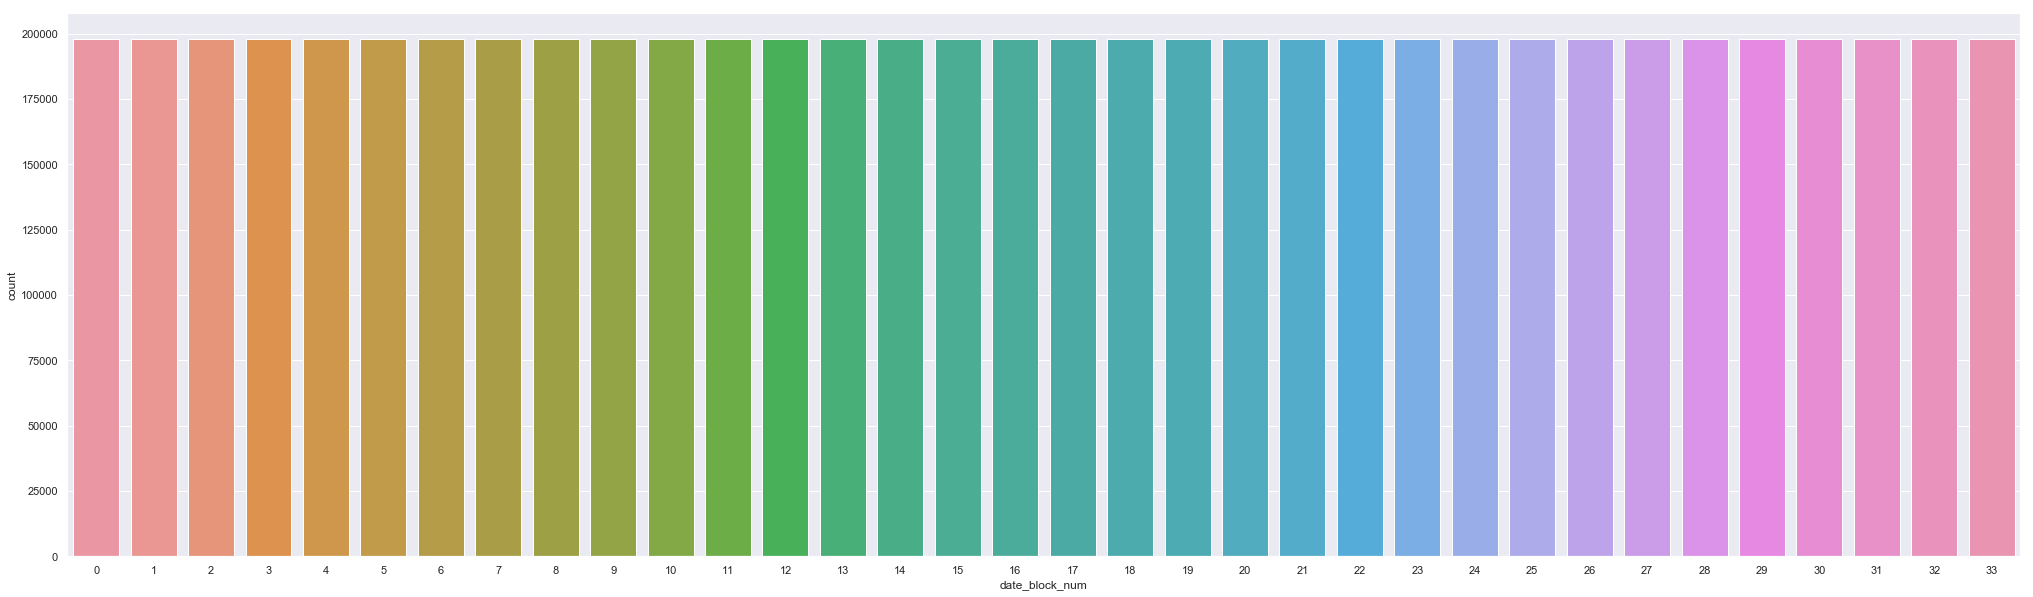

In [21]:
plt.figure(figsize=(35,10))
sns.countplot(x='date_block_num', data=train_monthly)
train_monthly


# Exploratory Data Analysis

In [22]:
# Grouping data for EDA.
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()


In [23]:
gp_month_mean.head()

,month,item_cnt
0,0,0.22
1,1,0.20
2,2,0.23
3,3,0.20
4,4,0.21


# How sales behave along the year ?

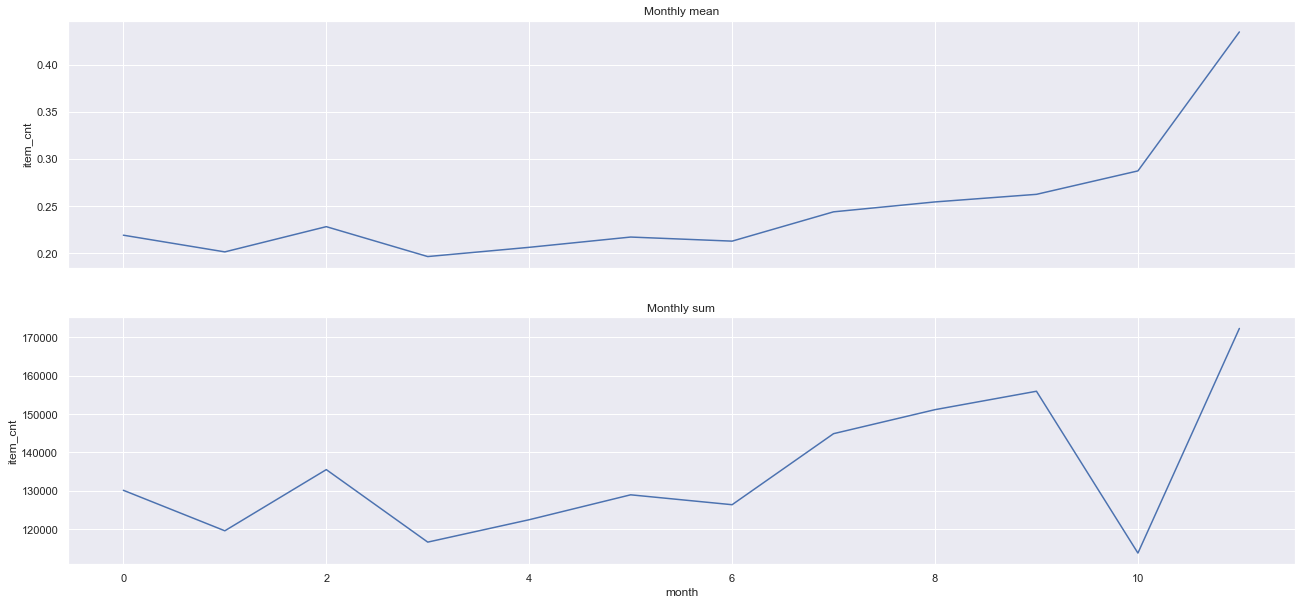

In [24]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()


As we can see we have a trending increase of item sales count (mean) towards the ending of the year.

# What category sells more?

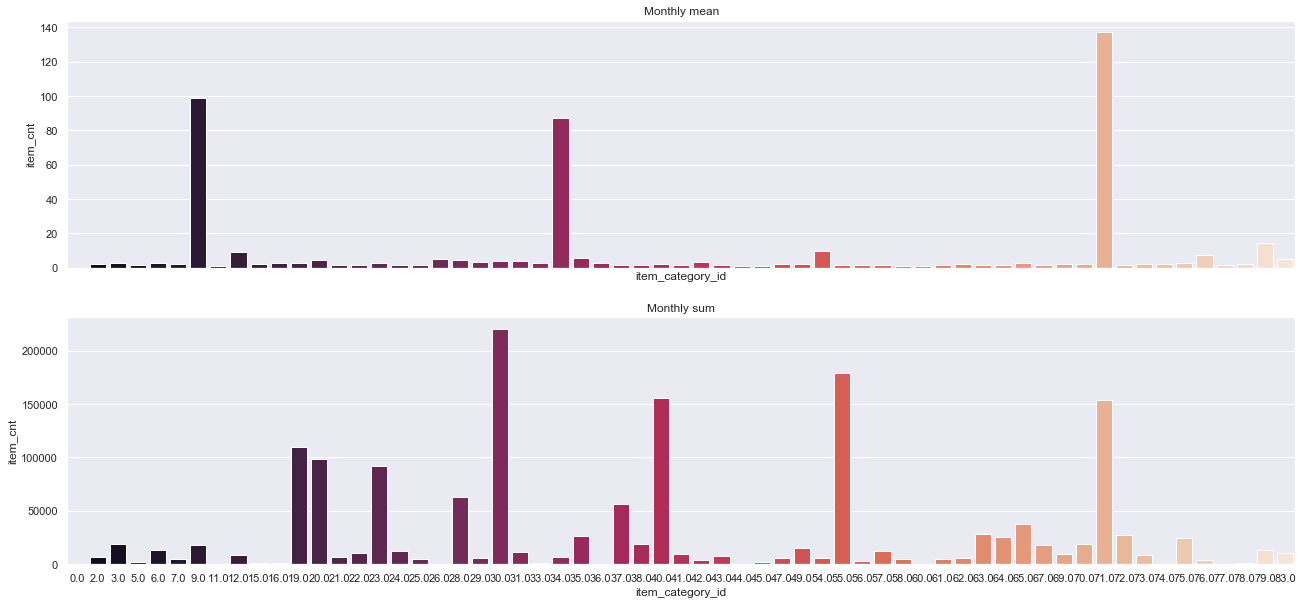

In [25]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

Also only few of the categories seems to hold most of the sell count.

# What shop sells more?

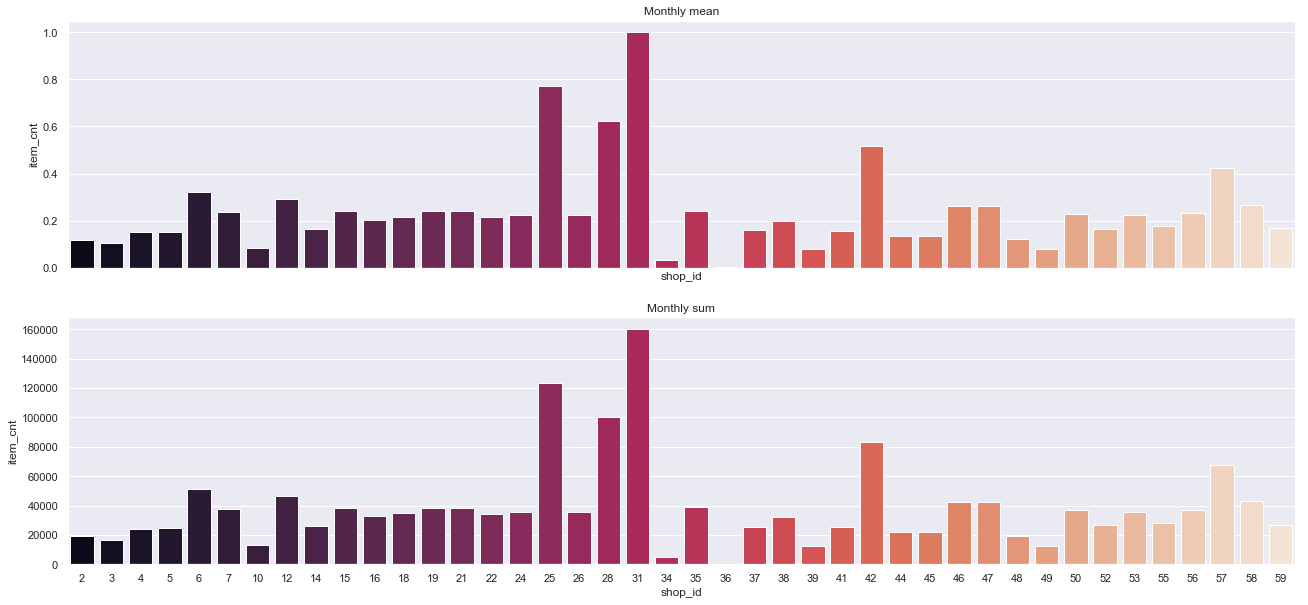

In [26]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

Most of the shops have a similar sell rate, but 3 of them have a much higher rate, this may be a indicative of the shop size.

# Checking for outliers

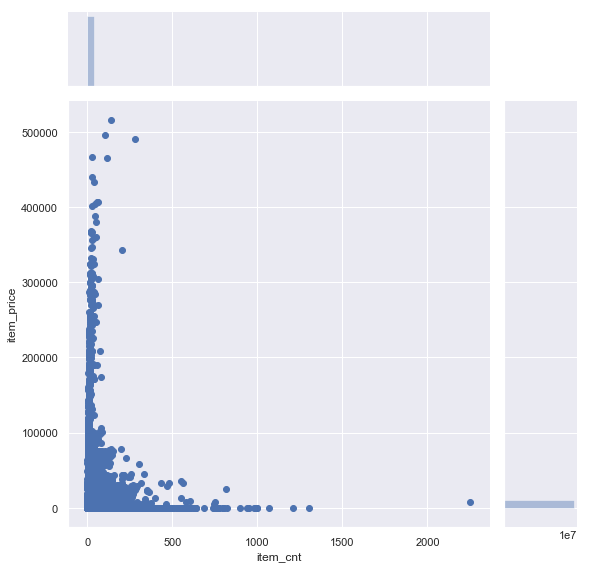

In [27]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

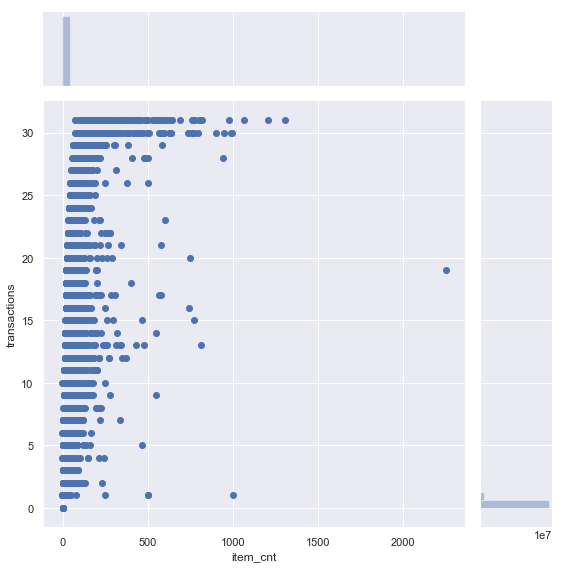

In [28]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()


# Feature "item_cnt" distribution.

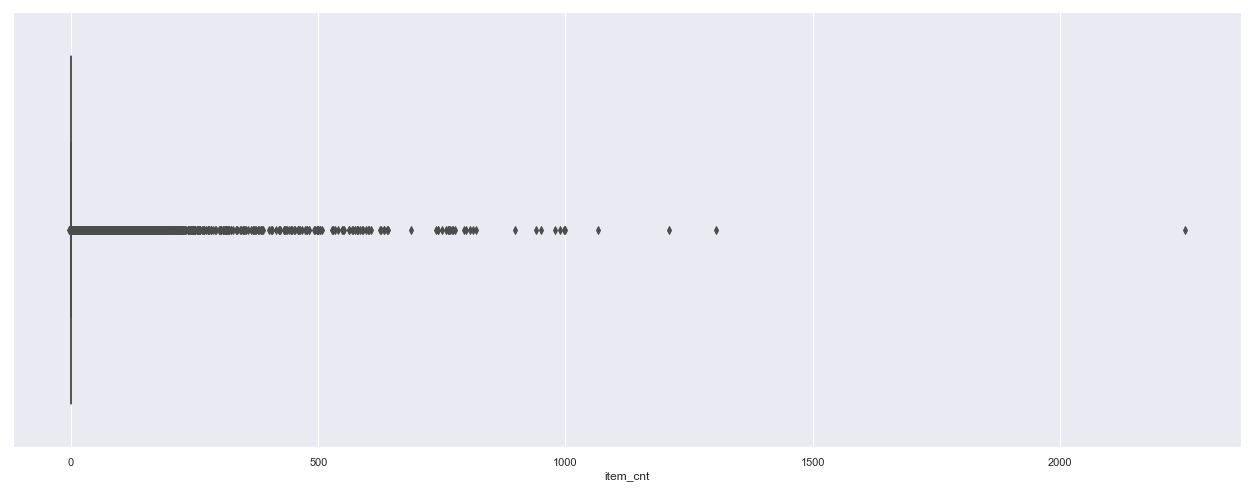

In [29]:
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

#### Removing outliers
I'll treat "item_cnt" > 20 and < 0, "item_price" >= 400000 as outliers, so I'll remove them.


In [30]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')


### Creating the label
Our label will be the "item_cnt" of the next month, as we are dealing with a forecast problem.

In [31]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

### Feature engineering

#### Unitary item prices.

In [32]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)


#### Group based features.

In [33]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')


#### How much each item's price changed from its (lowest/highest) historical price.

In [34]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']


#### Rolling window based features (window = 3 months).

In [35]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

#### Lag based features.

In [36]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

#### Item sales count trend.

In [37]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

### Dataset after feature engineering

In [38]:
train_monthly.head().T

,0,1,2,3,4
date_block_num,0.00,0.00,0.00,0.00,0.00
shop_id,2.00,2.00,2.00,2.00,2.00
item_id,5572.00,5643.00,5583.00,7893.00,7894.00
item_category_id,2.00,2.00,5.00,6.00,6.00
item_price,10730.00,4775.21,1188.30,5970.00,1490.00
mean_item_price,1532.86,2387.61,594.15,1990.00,1490.00
item_cnt,9.00,0.00,2.00,3.00,1.00
mean_item_cnt,1.29,0.00,1.00,1.00,1.00
transactions,7.00,2.00,2.00,3.00,1.00
year,2013.00,2013.00,2013.00,2013.00,2013.00


In [39]:
train_monthly.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,6728118.00,16.50,9.81,0.00,8.00,16.00,25.00,33.00
shop_id,6728118.00,31.64,17.56,2.00,16.00,35.00,47.00,59.00
item_id,6728118.00,11042.87,6209.70,30.00,5386.00,11266.00,16068.00,22167.00
item_category_id,6728118.00,3.75,13.16,0.00,0.00,0.00,0.00,83.00
item_price,6728118.00,169.80,1797.75,0.00,0.00,0.00,0.00,366860.00
mean_item_price,6728118.00,79.82,525.62,0.00,0.00,0.00,0.00,42990.00
item_cnt,6728118.00,0.19,0.91,0.00,0.00,0.00,0.00,20.00
mean_item_cnt,6728118.00,0.09,0.31,0.00,0.00,0.00,0.00,20.00
transactions,6728118.00,0.17,0.74,0.00,0.00,0.00,0.00,19.00
year,6728118.00,2013.94,0.80,2013.00,2013.00,2014.00,2015.00,2015.00


### Train/validation split
* we know the test set in on the future, so we should try to simulate the same distribution on our train/validation split.
* Our train set will be the first 3~28 blocks, validation will be last 5 blocks (29~32) and test will be block 33.
* I'm leaving the first 3 months out because we use a 3 month window to generate features, so these first 3 month won't have really windowed useful features.

In [40]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Train set records:', train_set.shape[0])
print('Validation set records:', validation_set.shape[0])
print('Test set records:', test_set.shape[0])

print('Train set records: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Validation set records: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))


Train set records: 4946785
Validation set records: 989412
Test set records: 197879
Train set records: 4946785 (74% of complete data)
Validation set records: 989412 (15% of complete data)


### Mean encoding.
* done after the train/validation split.

In [41]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')


In [42]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [43]:
# Integer features (used by catboost model).
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

### Build test set
We want to predict for "date_block_num" 34 so our test set will be block 33 and our predictions should reflect block 34 values. In other words we use block 33 because we want to forecast values for block 34.


In [44]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

### Replacing missing values.

In [45]:
sets = [X_train, X_validation, X_test]

# This was taking too long.
# Replace missing values with the median of each item.
# for dataset in sets:
#     for item_id in dataset['item_id'].unique():
#         for column in dataset.columns:
#             item_median = dataset[(dataset['item_id'] == item_id)][column].median()
#             dataset.loc[(dataset[column].isnull()) & (dataset['item_id'] == item_id), column] = item_median

# Replace missing values with the median of each shop.            
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [46]:
# I'm dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [47]:
X_train.to_csv('X_train.csv', index=False)
X_validation.to_csv('X_validation.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
Y_train.to_csv('Y_train.csv', index=False)
Y_validation.to_csv('Y_validation.csv', index=False)

### Test set

### Modeling the data

## Tree based models

### Catboost

In [48]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

0:	learn: 0.9354515	test: 0.9502233	best: 0.9502233 (0)	total: 3.87s	remaining: 32m 12s
50:	learn: 0.7047330	test: 0.8165372	best: 0.8165372 (50)	total: 1m 54s	remaining: 16m 43s
100:	learn: 0.6749258	test: 0.8093790	best: 0.8093105 (95)	total: 3m 44s	remaining: 14m 45s
150:	learn: 0.6670411	test: 0.8087666	best: 0.8083083 (139)	total: 5m 33s	remaining: 12m 51s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.8078152826
bestIteration = 161

Shrink model to first 162 iterations.


In [49]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


### Catboost feature importance

Dataset is provided, but PredictionValuesChange feature importance don't use it, since non-empty LeafWeights in model.


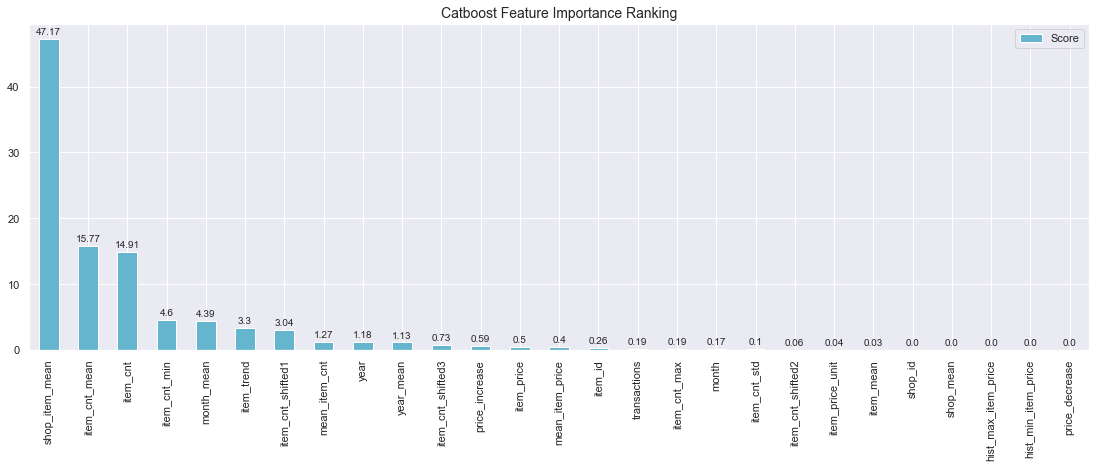

In [50]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [51]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [52]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))


Train rmse: 0.6658009312927786
Validation rmse: 0.8078152826380905


### Let's see how catboost performed with this "prediction x label" plot.
The closer the points are to the middle dashed line the better are the predictions.

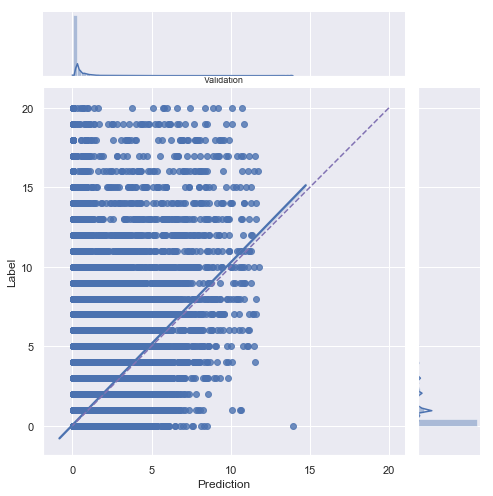

In [53]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    #sns.lineplot(x="Prediction", y="Label", data=performance_df).set_title("Validation")
    #sns.lineplot(x="month", y="item_cnt", data=performance_df, ax=axes[1]).set_title("Monthly sum")
    #sns.scatterplot(x="Prediction", y="Label",data=performance_df,colou)
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    #g.ax_joint.scatter(predictions,labels)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
# model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(catboost_val_pred, Y_validation, 'Validation')

### XGBoost

In [54]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [56]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[0]	validation_0-rmse:0.937797	validation_1-rmse:0.927783
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.682674	validation_1-rmse:0.803983
Stopping. Best iteration:
[13]	validation_0-rmse:0.697608	validation_1-rmse:0.801342



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=1000, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7)

### XGBoost feature importance

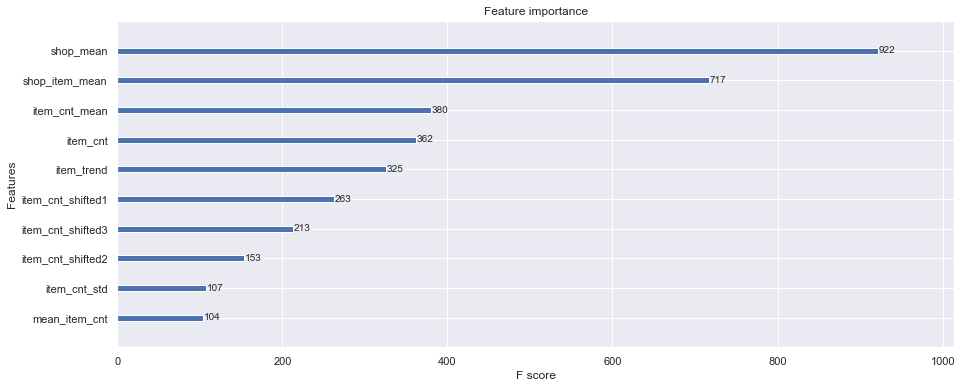

In [57]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [58]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [59]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))
#print('Test rmse:',np.sqrt(mean_squared_error(Y_test, xgb_test_pred)))

Train rmse: 0.7047821201315823
Validation rmse: 0.8032476623716235


### Let's see how XGBoosting performed with this "prediction x label" plot.

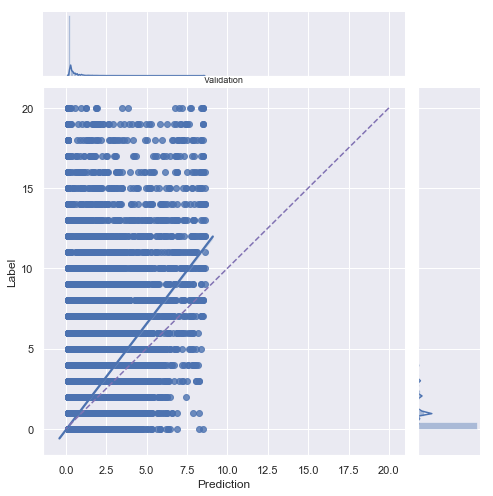

In [60]:
# model_performance_sc_plot(xgb_train_pred, Y_train, 'Train')
model_performance_sc_plot(xgb_val_pred, Y_validation, 'Validation')

### Random forest

In [61]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [62]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [63]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [64]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 0.6985868322226099
Validation rmse: 0.776123635046122


### Let's see how random forest performed with this "prediction x label" plot.

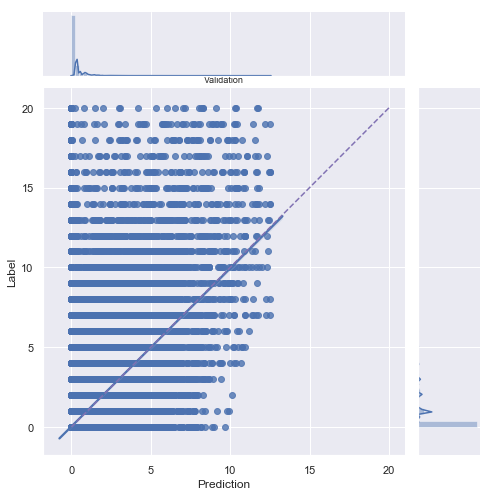

In [65]:
# model_performance_sc_plot(rf_train_pred, Y_train, 'Train')
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

## Linear models

### Linear Regression

In [66]:
# Use only part of features on linear Regression.
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

#### Normalizing features

In [67]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [68]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [69]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [70]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train rmse: 0.7347132326333323
Validation rmse: 0.775531109353346


### Let's see how linear regression performed with this "prediction x label" plot.

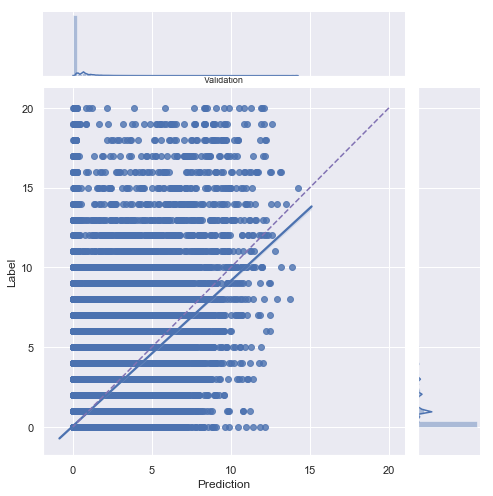

In [71]:
# model_performance_sc_plot(lr_train_pred, Y_train, 'Train')
model_performance_sc_plot(lr_val_pred, Y_validation, 'Validation')

## Clustering models

### KNN Regressor

In [72]:
# Use only part of features on KNN.
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

#### Normalizing features

In [73]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [74]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
          weights='uniform')

In [75]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [76]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train rmse: 0.48661440612348666
Validation rmse: 0.80036105644979


### Let's see how knn performed with this "prediction x label" plot.

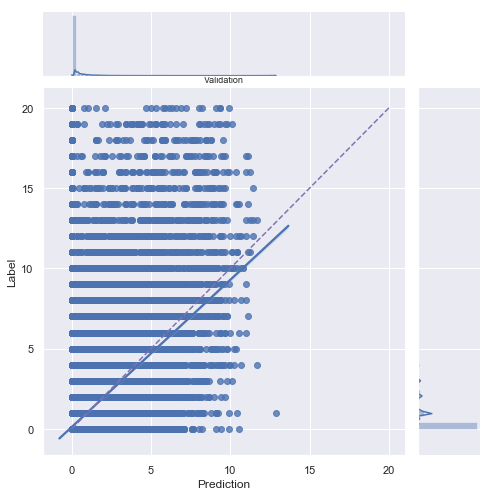

In [77]:
# model_performance_sc_plot(knn_train_pred, Y_train_sampled, 'Train')
model_performance_sc_plot(knn_val_pred, Y_validation, 'Validation')

### Create new datasets with the predictions from first level models.
* Here I'll be using a simple ensembling technique, I'll use the 1st level models predictions as the input for the 2nd level model, this way the 2nd level model will basically use the 1st level models predictions as features and learn where to give more weight.
* To use this technique I also need to use the 1st level models and make predictions on the test set, so I can use them on the 2nd level model.
* I could also pass the complete validation set with extra features (the 1st level models prediction) to the 2nd level model and let it do a little more work on finding the solution.

In [78]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

,catboost,xgbm,random_forest,linear_regression,knn,label
0,0.76,0.74,0.62,0.60,1.00,0
1,1.07,0.66,0.56,0.04,0.78,0
2,0.05,0.15,0.21,0.04,0.00,0
3,1.36,0.79,0.95,0.04,0.11,4
4,1.63,1.45,1.57,1.46,0.67,1
5,0.95,0.66,0.46,0.04,0.11,1
6,0.58,0.48,0.21,0.04,0.11,0
7,0.05,0.15,0.06,0.04,0.00,1
8,0.54,0.40,0.21,0.04,0.11,0
9,1.79,1.75,1.13,1.15,2.89,2


In [79]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,0.42,0.41,0.95,0.85,0.89
1,0.03,0.12,0.06,0.06,0.00
2,0.41,0.43,0.85,1.79,1.11
3,0.03,0.12,0.00,0.06,0.00
4,0.03,0.12,0.06,0.06,0.00


### Ensembling

* To combine the 1st level model predictions, I'll use a simple linear regression.
* As I'm only feeding the model with predictions I don't need a complex model.

#### Ensemble architecture:
* 1st level:
    * Catboost
    * XGBM
    * Random forest
    * Linear Regression
    * KNN
* 2nd level;
    * Linear Regression
    
#### Here is an  image to help the understanding
 
 <img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Predict%20Future%20Sales/Ensemble%20Kaggle.jpg" width="400">

### 2nd level model as a linear regression
* This is the model that will combine the other ones to hopefully make an overall better prediction.
* If the inputs to this mode were more complex, could be a good idea to split the data into train and validation again, this way you can check if the metal model is overfitting.

In [80]:
meta_model = LinearRegression(n_jobs=-1)

#### Trained on validation set using the 1st level models predictions as features.

In [81]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

#### Make predictions on test set using the 1st level models predictions as features.

In [82]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

#### Ensemble model metrics on validation set.

In [83]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))


Train rmse: 0.7653311772665253


#### Let's see how the meta model performed with this "prediction x label" plot.

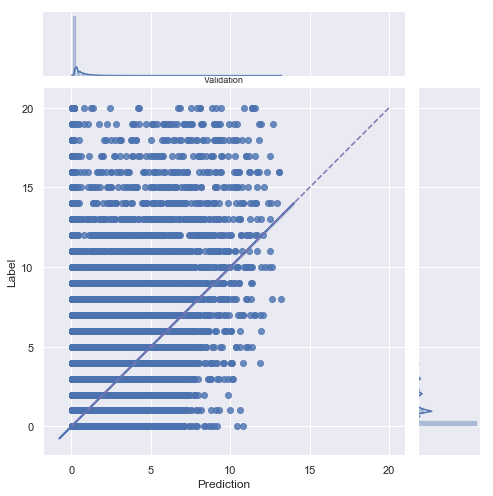

In [84]:
model_performance_sc_plot(ensemble_pred, Y_validation, 'Validation')

#### Output dataframe.

In [132]:
prediction_df = pd.DataFrame(test)
prediction_df['item_cnt_month'] = lr_test_pred.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=True)
prediction_df.head(10)

,item_cnt_month
ID,
0,0.85
1,0.06
2,1.79
3,0.06
4,0.06
5,1.00
6,1.29
7,0.06
8,2.07
